In [1]:
import numpy as np
import random
import cv2
import os
from imutils import paths
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K

from openpyxl import Workbook
import pandas as pd
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import keras

In [2]:
(X_train, y_train) , (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

In [3]:
#Normalize data
X_train = X_train / 255
X_test = X_test / 255

In [4]:
#Reshape 28*28 images into 1D array
X_train = X_train.reshape(len(X_train), 784)
X_test = X_test.reshape(len(X_test), 784)

In [5]:
def create_clients(image_list, label_list, num_clients=10, initial='clients'):
    ''' return: a dictionary with keys clients' names and value as 
                data shards - tuple of images and label lists.
        args: 
            image_list: a list of numpy arrays of training images
            label_list:a list of binarized labels for each image
            num_client: number of fedrated members (clients)
            initials: the clients'name prefix, e.g, clients_1 
            
    '''
    client_names = ['{}_{}'.format(initial, i+1) for i in range(num_clients)]

    data = list(zip(image_list, label_list))
    random.shuffle(data)

    size = len(data)//num_clients
    shards = [data[i:i + size] for i in range(0, size*num_clients, size)]

    #Number of clients must equal number of shards
    assert(len(shards) == len(client_names))

    return {client_names[i] : shards[i] for i in range(len(client_names))} 

In [6]:
def create_clients_with_attack(image_list, label_list, num_clients, num_malicious, initial):
    client_names = ['{}_{}'.format(initial, i+1) for i in range(num_clients)]
   
    data = list(zip(image_list, label_list))
    random.shuffle(data)
    
    size = len(data) // num_clients
    shards = [data[i:i + size] for i in range(0, size * num_clients, size)]
    
    #Number of clients must equal number of shards
    assert(len(shards) == len(client_names))
    
    #Flip labels
    for i in range(num_malicious):
        for j in range(len(shards[i])):
            if shards[i][j][1] == 6:
                shards[i][j] = (shards[i][j][0], 0)
    
    return {client_names[i]: shards[i] for i in range(len(client_names))}

In [7]:
num_malicious=4
clients = create_clients_with_attack(X_train, y_train, 10, num_malicious, 'client')

In [8]:
def batch_data(data_shard, bs=32):
    '''Takes in a clients data shard and create a tfds object off it
    args:
        shard: a data, label constituting a client's data shard
        bs:batch size
    return:
        tfds object'''
    #Seperate shard into data and labels lists
    data, label = zip(*data_shard)
    dataset = tf.data.Dataset.from_tensor_slices((list(data), list(label)))
    return dataset.shuffle(len(label)).batch(bs)

In [9]:
#Process and batch the training data for each client
clients_batched = dict()
for (client_name, data) in clients.items():
    clients_batched[client_name] = batch_data(data)
    
#Process and batch the test set  
test_batched = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(len(y_test))

In [10]:
from tensorflow.keras.layers import Input

class SimpleMLP:
    @staticmethod
    def build(shape, classes):
        model = Sequential()
        model.add(Input(shape=(shape,)))
        model.add(Dense(200, activation="relu"))
        model.add(Dense(200, activation="relu"))
        model.add(Dense(classes, activation="softmax"))
        return model

In [11]:
lr = 0.01 
comms_round = 10
loss='sparse_categorical_crossentropy'
metrics = ['accuracy']
optimizer = SGD(learning_rate=lr,   
                momentum=0.9
               )        

In [12]:
def weight_scalling_factor(clients_trn_data, client_name):
    client_names = list(clients_trn_data.keys())
    bs = list(clients_trn_data[client_name])[0][0].shape[0]
    #First calculate the total training data points across clinets
    global_count = sum([tf.data.experimental.cardinality(clients_trn_data[client_name]).numpy() for client_name in client_names])*bs
    #Get the total number of data points held by a client
    local_count = tf.data.experimental.cardinality(clients_trn_data[client_name]).numpy()*bs
    return local_count/global_count

def scale_model_weights(weight, scalar):
    weight_final = []
    steps = len(weight)
    for i in range(steps):
        weight_final.append(scalar * weight[i])
    return weight_final

def sum_scaled_weights(scaled_weight_list):
    '''Return the sum of the listed scaled weights. The is equivalent to scaled avg of the weights'''
    avg_grad = list()
    for grad_list_tuple in zip(*scaled_weight_list):
        layer_mean = tf.math.reduce_sum(grad_list_tuple, axis=0)
        avg_grad.append(layer_mean)    
    return avg_grad

def test_model(X_test, Y_test, model, comm_round):
    scce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    logits = model.predict(X_test)
    loss = scce(Y_test, logits).numpy()  
    pred_labels = tf.argmax(logits, axis=1).numpy()
    true_labels = Y_test
    acc = accuracy_score(true_labels, pred_labels)
    print(f'comm_round: {comm_round} | global_acc: {acc:.3%} | global_loss: {loss:.4f}')
    return acc, loss

In [13]:
def save_with_labels_and_top_values_to_excel(writer, weights, comm_round):
    '''
    Save weights with labels to an Excel writer, with sheets for each layer per communication round.
    Also saves sheets for the top 5 largest values per layer (including their indexes).
    '''
    if weights:
        for i, layer_weights in enumerate(weights):
            if isinstance(layer_weights, tf.Tensor):
                layer_weights = layer_weights.numpy()
    
            #Ensure column vector layers are properly reshaped
            if layer_weights.ndim == 1:  #Bias terms or fully connected layer outputs
                df = pd.DataFrame(layer_weights.reshape(-1, 1))  # Convert (n,) to (n,1)
            else:
                df = pd.DataFrame(layer_weights)  # Standard case
    
            #Generate row and column labels
            if i == 0:
                row_labels = [f"pixel at ({i},{j})" for i in range(1, 29) for j in range(1, 29)]
                column_labels = [f"neuron {i+1}" for i in range(df.shape[1])]
            else:
                row_labels = [f"neuron {i+1}" for i in range(df.shape[0])]
                column_labels = [f"neuron {j+1}" for j in range(df.shape[1])]
    
            df.index = row_labels
            df.columns = column_labels
            
            sheet_name = f"Layer_{i}_Round_{comm_round}"
            df.to_excel(writer, sheet_name=sheet_name, index=True) 
    
            #Extract and save the top 5 largest values along with their indexes
            flat_values = layer_weights.flatten()
            flat_indices = np.argsort(flat_values)[-5:][::-1]  #Get top 5 indices (sorted in descending order)
            top_5_values = flat_values[flat_indices]  #Get corresponding values

            #Consider cases where layer_weights is 1D or (n,1)
            if layer_weights.ndim == 1 or layer_weights.shape[-1] == 1:
                top_5_index_labels = [f"(row {r+2})" for r in flat_indices]  
            else:
                top_5_indexes = [np.unravel_index(idx, layer_weights.shape) for idx in flat_indices]
                top_5_index_labels = [f"({r+2},{c+2})" for r, c in top_5_indexes]  
            
            top_5_df = pd.DataFrame({
                "Rank": [1, 2, 3, 4, 5],
                "Value": top_5_values,
                "Index": top_5_index_labels 
            })
            top_sheet_name = f"Layer_{i}_Top5_Round_{comm_round}"
            top_5_df.to_excel(writer, sheet_name=top_sheet_name, index=False)  

In [14]:
def compute_asr(model, poisoned_class, target_class, X_test, y_test):
    X_test = X_test.numpy()
    poisoned_indices = np.where(y_test == poisoned_class)[0]
    poisoned_samples = X_test[poisoned_indices]
    
    predictions = model.predict(poisoned_samples)
    predicted_classes = np.argmax(predictions, axis=1)
    
    attack_success_rate = np.mean(predicted_classes == target_class)
    print(f"Class {poisoned_class} flipped to {target_class} - Attack Success Rate: {attack_success_rate:.3%}")
    
    return attack_success_rate

In [15]:
def compute_recall_for_class(y_true, y_pred, poisoned_class, target_class):
    '''
    - True Positives (TP): The number of times poisoned_class is correctly predicted.
    - False Negatives (FN): The number of times poisoned_class is incorrectly predicted as target_class.
    '''
    #TP: y_true is target_class and y_pred is also target_class
    TP = np.sum((y_true == poisoned_class) & (y_pred == poisoned_class))
    
    #FN: y_true is target_class but predicted as false_class
    FN = np.sum((y_true == poisoned_class) & (y_pred == target_class))

    #Avoid division by zero
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0

    print(f"Class {poisoned_class} flipped to {target_class} - TP: {TP}, FN: {FN}, Recall: {recall:.3%}")
    return recall

In [16]:
client_names = list(clients.keys())
malicious_clients = client_names[:num_malicious]
benign_clients = client_names[num_malicious:]

random.shuffle(client_names)

print("Malicious Clients:", malicious_clients)
print("Benign Clients:", benign_clients)

#Initialize global model
smlp_global = SimpleMLP()
global_model = smlp_global.build(784, 10)

global_accuracies = []
attack_success_rates = []
class_recalls = []

benign_excel_writer = pd.ExcelWriter("Benign_Clients_Weights.xlsx", engine="openpyxl")
malicious_excel_writer = pd.ExcelWriter("Malicious_Clients_Weights.xlsx", engine="openpyxl")
global_excel_writer = pd.ExcelWriter("Global_Weights.xlsx", engine="openpyxl")
avg_excel_writer = pd.ExcelWriter("Averages_and_Differences.xlsx", engine="openpyxl")

#Global training loop
for comm_round in range(comms_round):
    clients_batched = {
        client_name: batch_data(data) 
        for client_name, data in clients.items()
    }
    test_batched = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(len(y_test))
    
    global_weights = global_model.get_weights()

    benign_scaled_weights = []
    malicious_scaled_weights = []

    client_names = list(clients_batched.keys())
    random.shuffle(client_names)
    
    #Loop through each client and create new local model
    for client_idx, client in enumerate(client_names):
        smlp_local = SimpleMLP()
        local_model = smlp_local.build(784, 10)
        
        local_optimizer = Adam()
        local_model.compile(
            loss=loss, 
            optimizer=local_optimizer, 
            metrics=metrics
        )
        
        #Set local model weights to the weights of the global model
        local_model.set_weights(global_weights)
        local_model.fit(clients_batched[client], epochs=1, verbose=0)
        
        #Scale the model weights and add to the appropriate list
        scaling_factor = weight_scalling_factor(clients_batched, client)
        scaled_weights = scale_model_weights(local_model.get_weights(), scaling_factor)
        if client in benign_clients:
            benign_scaled_weights.append(scaled_weights)
        elif client in malicious_clients:
            malicious_scaled_weights.append(scaled_weights)
        
        #Clear session to free memory
        K.clear_session()

    #Compute average weights for benign and malicious clients
    benign_avg_weights = sum_scaled_weights(benign_scaled_weights) if benign_scaled_weights else None
    malicious_avg_weights = sum_scaled_weights(malicious_scaled_weights) if malicious_scaled_weights else None

    #Compute the difference between benign and malicious weights
    weight_differences = [
        benign_layer - malicious_layer
        for benign_layer, malicious_layer in zip(benign_avg_weights, malicious_avg_weights)
    ] if benign_avg_weights and malicious_avg_weights else None

    
    #Update global model with average weights
    combined_weights = benign_scaled_weights + malicious_scaled_weights
    average_weights = sum_scaled_weights(combined_weights) if combined_weights else global_weights
    global_model.set_weights(average_weights)

    #Save benign, malicious, global weights, and their differences with top 5 values
    save_with_labels_and_top_values_to_excel(benign_excel_writer, benign_avg_weights, comm_round)
    save_with_labels_and_top_values_to_excel(malicious_excel_writer, malicious_avg_weights, comm_round)
    save_with_labels_and_top_values_to_excel(avg_excel_writer, weight_differences, comm_round)
    save_with_labels_and_top_values_to_excel(global_excel_writer, global_model.get_weights(), comm_round)

    #Test global model and print out metrics
    for (X_test, Y_test) in test_batched:
        global_acc, global_loss = test_model(X_test, Y_test, global_model, comm_round)
        global_accuracies.append(global_acc)

        logits = global_model.predict(X_test)
        pred_labels = tf.argmax(logits, axis=1).numpy()
        true_labels = Y_test.numpy()
        class_recall = compute_recall_for_class(true_labels, pred_labels, 6, 0)
        class_recalls.append(class_recall)
        
        asr = compute_asr(global_model, 6, 0, X_test, y_test)
        attack_success_rates.append(asr)

benign_excel_writer.close()
malicious_excel_writer.close()
global_excel_writer.close()
avg_excel_writer.close()

Malicious Clients: ['client_1', 'client_2', 'client_3', 'client_4']
Benign Clients: ['client_5', 'client_6', 'client_7', 'client_8', 'client_9', 'client_10']


2025-01-12 10:13:58.230564: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-12 10:13:58.655444: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-12 10:13:59.511110: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-12 10:14:01.236914: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 291us/step
comm_round: 0 | global_acc: 77.300% | global_loss: 1.7587
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step
Class 6 flipped to 0 - TP: 0, FN: 295, Recall: 0.000%
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step
Class 6 flipped to 0 - Attack Success Rate: 29.500%


2025-01-12 10:14:08.381418: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step
comm_round: 1 | global_acc: 78.630% | global_loss: 1.7159
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step
Class 6 flipped to 0 - TP: 0, FN: 340, Recall: 0.000%
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 282us/step
Class 6 flipped to 0 - Attack Success Rate: 34.000%


2025-01-12 10:14:20.555892: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step
comm_round: 2 | global_acc: 79.890% | global_loss: 1.6977
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step
Class 6 flipped to 0 - TP: 2, FN: 352, Recall: 0.565%
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step
Class 6 flipped to 0 - Attack Success Rate: 35.200%
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step
comm_round: 3 | global_acc: 81.230% | global_loss: 1.6882
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step
Class 6 flipped to 0 - TP: 71, FN: 345, Recall: 17.067%
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step
Class 6 flipped to 0 - Attack Success Rate: 34.500%
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step
comm_round: 4 | global_acc: 82.150% | global_loss: 1.6843
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step
Class 6 flipped to 0 - TP: 136, FN: 368, Recall: 26.984%
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step
Class 6 flipped to 0 - Attack Success Rate: 36.800%


2025-01-12 10:14:52.445074: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step
comm_round: 5 | global_acc: 82.210% | global_loss: 1.6833
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step
Class 6 flipped to 0 - TP: 146, FN: 356, Recall: 29.084%
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step
Class 6 flipped to 0 - Attack Success Rate: 35.600%
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step
comm_round: 6 | global_acc: 83.060% | global_loss: 1.6778
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step
Class 6 flipped to 0 - TP: 210, FN: 354, Recall: 37.234%
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step
Class 6 flipped to 0 - Attack Success Rate: 35.400%
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step
comm_round: 7 | global_acc: 83.140% | global_loss: 1.6796
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step
Class 6 flipped to 0 - TP: 196, FN: 345, Recall: 36.229%
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 292us/step
Class 6 flipped to 0 - Attack Success Rate: 34.500%
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 284us/step
comm_round: 8 | global_acc: 83.920% | global_loss: 1.6719
313/313 ━━━━━━━━━

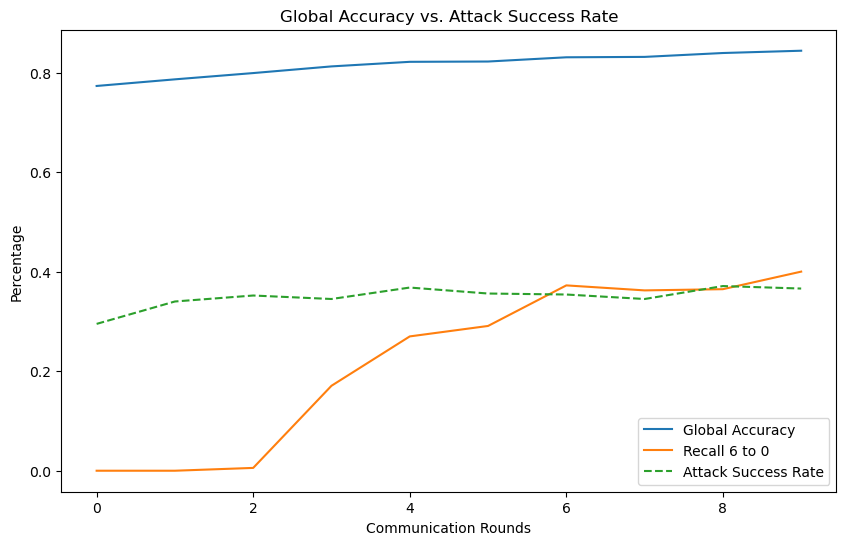

In [17]:
rounds = range(comms_round)
plt.figure(figsize=(10, 6))
plt.plot(rounds, global_accuracies, label='Global Accuracy')
plt.plot(rounds, class_recalls, label='Recall 6 to 0')
plt.plot(rounds, attack_success_rates, label='Attack Success Rate', linestyle='--')
plt.xlabel('Communication Rounds')
plt.ylabel('Percentage')
plt.title('Global Accuracy vs. Attack Success Rate')
plt.legend()
plt.show()